In [14]:
!pip install yfinance

In [15]:
import yfinance as yf
import pandas as pd
import os

In [16]:

# Liste des symboles des actions à sélectionner
stock_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']


In [17]:
def fetch_portfolio(stock_list):
    pf_final = pd.DataFrame()
    for stock in stock_symbols:
        pf = yf.Ticker(stock)
        pf = pf.history(period="max")
        pf_final = pd.concat([pf_final, pf])
    return pf_final

In [18]:
if os.path.exists("./data/portfolio01.csv"):
    portfolio01 = pd.read_csv("./data/portfolio01.csv", index_col=0)
else:
    portfolio01 = fetch_portfolio(stock_symbols)
    portfolio01.to_csv("./data/portfolio01.csv")

In [19]:
portfolio01.index = pd.to_datetime(portfolio01.index)

In [20]:
portfolio01

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087548,0.087548,0.087117,0.087117,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.091861,0.092292,0.091861,0.091861,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-05 00:00:00-05:00,184.259995,184.679993,175.009995,181.059998,134294400,0.0,0.0
2024-02-06 00:00:00-05:00,177.210007,186.490005,177.110001,185.100006,122676000,0.0,0.0
2024-02-07 00:00:00-05:00,188.179993,189.789993,182.679993,187.580002,111535200,0.0,0.0


<Axes: xlabel='Date'>

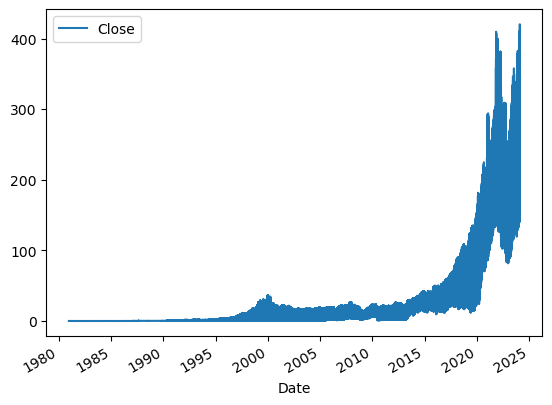

In [21]:
portfolio01.plot.line(y="Close", use_index=True)

In [22]:
del portfolio01["Dividends"]
del portfolio01["Stock Splits"]

In [23]:
portfolio01["Tomorrow"] = portfolio01["Close"].shift(-1)

In [24]:
portfolio01["Target"] = (portfolio01["Tomorrow"] > portfolio01["Close"]).astype(int)

In [ ]:
portfolio01 = portfolio01.loc["1990-01-01":].copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = portfolio01.iloc[:-100]
test = portfolio01.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(portfolio01, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = portfolio01.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    portfolio01[ratio_column] = portfolio01["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    portfolio01[trend_column] = portfolio01.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [ ]:
portfolio01 = portfolio01.dropna(subset=portfolio01.columns[portfolio01.columns != "Tomorrow"])

In [ ]:
portfolio01

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(portfolio01, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

In [ ]:
predictions